## Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os

import torch
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt

from collections import OrderedDict 
from sklearn import metrics, model_selection
from torch.optim import Adam

sys.path.append(os.path.abspath(''))

import utils.more_torch_functions as mtf
import datasets

from utils.custom_activations import StepActivation, StepFunction
from utils.modules import Parallel, MaxLayer, MaxHierarchicalLayer
from utils.misc import cross_valid, combine_prompts, cov_score

# torch.autograd.set_detect_anomaly(True)

## Load data

In [3]:
np_x, np_y = datasets.DiabetesDataset.get_dataset(balancing=True, discretizing=False, hot_encoding=True)
x_data, y_data = torch.Tensor(np_x), torch.Tensor(np_y)
input_size = x_data.size(1)
print(x_data.size())

torch.Size([536, 8])


## Hooks

In [4]:
intermediate_outputs = {}
def get_intermediate_outputs(name):
    def hook(model, input, output):
        if model.training:
            intermediate_outputs.setdefault(name, dict())["train"] = output
        else:
            intermediate_outputs.setdefault(name, dict())["valid"] = output
    return hook

def true_label_for_backward(train, valid):
    def hook(model, input):
        if model.training:
            model.true_labels = train
        else:
            model.true_labels = valid
    return hook

# créer hook fonction de perte pour meilleur backward ? (comparer individuellement les sorties des réseaux ???)

## Networks

### Network parts

In [5]:
class ApproxNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        hl1 = 10

        self.nn = nn.Sequential(OrderedDict([
            ('l1', nn.Linear(input_size,hl1)),
            ('a1', StepActivation()),
            ('l2', nn.Linear(hl1,1)),
            ('a2', StepActivation())
        ]))        

    def forward(self, x):
        x = self.nn(x)

        return x

class BigNet(nn.Module):
    def __init__(self):
        super().__init__()

        hl1 = 50
        hl2 = 25

        self. nn = nn.Sequential(OrderedDict([
            ('l1', nn.Linear(input_size,hl1)),
            ('a1', nn.Sigmoid()),
            ('l2', nn.Linear(hl1,hl2)),
            ('a2', nn.Sigmoid()),
            ('l3', nn.Linear(hl2,1)),
            ('a3', StepActivation()),
        ]))
    
    def forward(self, x):
        x = self.nn(x)

        return x

### Previous Network (and related)

In [6]:
class NetResults():
    def __init__(self, *tensors):
        for tensor in tensors:
            self.register_result(tensor)

    def __getattr__(self, name):
        if hasattr(self.x, name):
            return getattr(self.x, name)
        else:
            raise AttributeError(f"'{type(self).__name__}' object has no attribute '{name}'")
    
    def __dir__(self):
        return dir(self.x)

    def __str__(self):
        return '\n'.join([str(t) for t in self.tensors()])

    def tensors(self):
        for v in self.__dict__.values():
            yield v

    def detach(self):
        for t in self.tensors():
            t.detach()
        return self
    
    def round(self, *args):
        for t in self.tensors():
            t.round(*args)
        return self

class Netv1(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.a1 = ApproxNet()
        self.a2 = ApproxNet()
        self.nn = BigNet()

    def forward(self, x):
        xa1 = self.a1(x)
        xa2 = self.a2(x)
        xnn = self.nn(x)

        res = [xnn, xa1, xa2]

        # /!\ to change for backward propagation /!\
        x = mtf.bitwise_big_or(*[(torch.round(t)).to(bool) for t in res])
        # maximum ???
        # xmax = mtf.maximum(res)
        # x = torch.where(xmax > 0.5, xmax, xnn)

        x = NetResults(x, *res)

        return x

### New Network definition

In [7]:
class Netv2(nn.Module):
    def __init__(self):
        super().__init__()

        self.net = nn.Sequential(OrderedDict([
            ('nets', Parallel(OrderedDict([
                ('nn', BigNet()),
                ('apx1', ApproxNet()),
                ('apx2', ApproxNet()),
                ('apx3', ApproxNet()),
            ]))),
            ('or_', MaxLayer()),
        ]))

    def forward(self, input):
        return self.net(input)

## Network evaluation

In [8]:
model = Netv2()
criterion = nn.BCELoss()
optimizer = Adam(model.parameters(), lr=1e-2, weight_decay=1e-6)

model.net.nets.register_forward_hook(get_intermediate_outputs("parallel_out"))
hook_label = lambda y_train, y_test : model.net.or_.register_forward_pre_hook(true_label_for_backward(y_train, y_test))

num_folds = 10
skf = model_selection.StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=104)
bnet_split_res = cross_valid(x_data, y_data, model, criterion, optimizer, skf, hook_label, max_epoch=500)

nn_children = [name for name, _ in model.net.nets.named_children()]
dict_metrics = {(modelname, metric, key): list() for modelname in ["net"] + nn_children
                for metric in ("f1score", "coverage0", "coverage1") for key in ("valid", "train")}

for i, (train_pred, train_true, valid_pred, valid_true) in enumerate(bnet_split_res):
    out_nns = intermediate_outputs["parallel_out"]
    for d in out_nns.values():
        for k, v in d.items():
            d[k] = v.detach().round()

    f1prompts = []
    covprompts = []
    sep_model = f"{'|':^9}"
    for k, pred, true in [["valid", valid_pred, valid_true], ["train", train_pred, train_true]]:
        net_f1_score = metrics.f1_score(true, pred, average="binary")
        net_cov_score = cov_score(true, pred)
        dict_metrics[('net', 'f1score', k)].append(net_f1_score)
        dict_metrics[('net', 'coverage1', k)].append(net_cov_score[1])
        dict_metrics[('net', 'coverage0', k)].append(net_cov_score[0])
        covprompts.append(f"{'Net':<15}{net_cov_score[0]:.3f}{sep_model}{'Net':<15}{net_cov_score[1]:.3f}")

        prev_modelname = 'Net'
        prev_f1_score = net_f1_score

        for c, cname in enumerate(nn_children):
            modelname = 'Big Network'if c==0 else f'Approx {c}'
            model_pred = out_nns[k][cname]

            model_f1_score = metrics.f1_score(true, model_pred, average="binary")
            model_cov_score = cov_score(true, model_pred)

            if c%2==0:
                f1prompts.append(f"{prev_modelname:<15}{prev_f1_score:.3f}{sep_model}{modelname:<15}{model_f1_score:.3f}")
            else:
                prev_modelname = modelname
                prev_f1_score = model_f1_score
            covprompts.append(f"{modelname:<15}{model_cov_score[0]:.3f}{sep_model}{modelname:<15}{model_cov_score[1]:.3f}")

            dict_metrics[(cname, 'f1score', k)].append(model_f1_score)
            dict_metrics[(cname, 'coverage1', k)].append(model_cov_score[1])
            dict_metrics[(cname, 'coverage0', k)].append(model_cov_score[0])

        if c%2:
            f1prompts.append(f"{modelname:<15}{model_f1_score:.3f}{sep_model}{'':<20}")

    sep_tv = f"{'||':^10}"
    print(f"Fold {i+1:3} :            {'Valid':^49}{sep_tv}{'Train':^49}",
        f"\tF1 score      {combine_prompts(f1prompts, sep_tv)}",
        f"\tCoverage      {combine_prompts(covprompts, sep_tv)}",
        sep='\n')

Fold   1 :                                  Valid                          ||                          Train                      
	F1 score      Net            0.769    |    Big Network    0.681    ||    Net            0.943    |    Big Network    0.972
	              Approx 1       0.651    |    Approx 2       0.585    ||    Approx 1       0.670    |    Approx 2       0.636
	              Approx 3       0.526    |                            ||    Approx 3       0.592    |                        
	Coverage      Net            0.815    |    Net            0.741    ||    Net            0.929    |    Net            0.954
	              Big Network    0.852    |    Big Network    0.593    ||    Big Network    1.000    |    Big Network    0.946
	              Approx 1       0.926    |    Approx 1       0.519    ||    Approx 1       0.979    |    Approx 1       0.515
	              Approx 2       0.926    |    Approx 2       0.444    ||    Approx 2       0.967    |    Approx 2       0.481
	

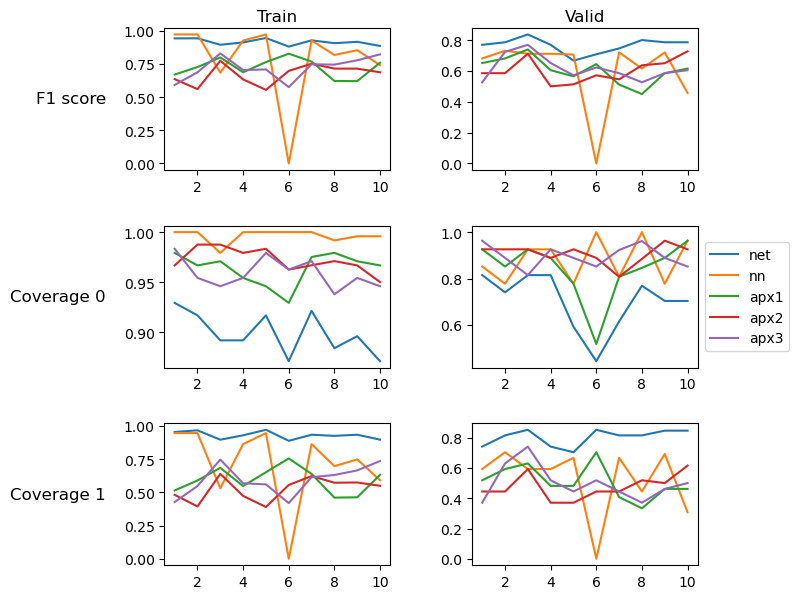

In [24]:
fig, axs = plt.subplots(3,2)

x_axis = list(range(1, num_folds+1))
mtypeconv = {"f1score": 0, "coverage0": 1, "coverage1": 2}
dtypeconv = {"train": 0, "valid": 1}
for ((modelname, metrictype, dataset), metric) in dict_metrics.items():
    ax = axs[mtypeconv[metrictype], dtypeconv[dataset]]
    ax.plot(x_axis, metric, label=modelname)
    # ax.set_ylim(0,1)

axs[1,1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

cols = ["Train", "Valid"]
rows = ["F1 score", "Coverage 0", "Coverage 1"]

pad = 5
for ax, col in zip(axs[0], cols):
    ax.annotate(col, xy=(0.5, 1), xytext=(0, pad),
                xycoords='axes fraction', textcoords='offset points',
                size='large', ha='center', va='baseline')

for ax, row in zip(axs[:,0], rows):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center')

fig.tight_layout()
fig.subplots_adjust(left=0, top=1.2)

In [10]:
df_metrics = pd.DataFrame.from_dict(dict_metrics, orient='index')
mean_metrics = df_metrics.mean(axis=1)

f1_mean_prompts = []
cov_mean_prompts = []

for k in ["valid", "train"]:
    prev_modelname = 'Net'
    prev_f1_avg = mean_metrics[('net', 'f1score', 'valid')]
    cov_mean_prompts.append(f"{'Net':<15}{mean_metrics[('net', 'coverage0', k)]:.3f}{sep_model}{'Net':<15}{mean_metrics[('net', 'coverage1', k)]:.3f}")
    for c, cname in enumerate(nn_children):
        modelname = 'Big Network'if c==0 else f'Approx {c}'
        model_f1_avg = mean_metrics[(cname, 'f1score', k)]
        model_cov0_avg = mean_metrics[(cname, 'coverage0', k)]
        model_cov1_avg = mean_metrics[(cname, 'coverage1', k)]

        if c%2==0:
            f1_mean_prompts.append(f"{prev_modelname:<15}{prev_f1_avg:.3f}{sep_model}{modelname:<15}{model_f1_avg:.3f}")
        else:
            prev_modelname = modelname
            prev_f1_score = model_f1_score

        cov_mean_prompts.append(f"{modelname:<15}{model_cov0_avg:.3f}{sep_model}{modelname:<15}{model_cov1_avg:.3f}")
    
    if c%2:
        f1_mean_prompts.append(f"{modelname:<15}{model_f1_score:.3f}{sep_model}{'':<20}")

print(f"Average  :            {'Valid':^49}{sep_tv}{'Train':^49}",
      f"\tF1 score      {combine_prompts(f1_mean_prompts, sep_tv)}",
      f"\tCoverage      {combine_prompts(cov_mean_prompts, sep_tv)}",
      sep='\n')

Average  :                                  Valid                          ||                          Train                      
	F1 score      Net            0.765    |    Big Network    0.605    ||    Net            0.765    |    Big Network    0.787
	              Approx 1       0.765    |    Approx 2       0.603    ||    Approx 1       0.765    |    Approx 2       0.672
	              Approx 3       0.822    |                            ||    Approx 3       0.822    |                        
	Coverage      Net            0.701    |    Net            0.803    ||    Net            0.899    |    Net            0.930
	              Big Network    0.881    |    Big Network    0.526    ||    Big Network    0.996    |    Big Network    0.713
	              Approx 1       0.839    |    Approx 1       0.507    ||    Approx 1       0.964    |    Approx 1       0.594
	              Approx 2       0.906    |    Approx 2       0.475    ||    Approx 2       0.972    |    Approx 2       0.525
	

In [11]:
model_ref = BigNet()
criterion_ref = nn.BCELoss()
optimizer_ref = Adam(model_ref.parameters(), lr=1e-2, weight_decay=1e-6)
skf = model_selection.StratifiedKFold(n_splits=10, shuffle=True, random_state=104)
ref_split_res = cross_valid(x_data, y_data, model_ref, criterion_ref, optimizer_ref, skf, max_epoch=500)

ref_metrics = {('ref_model', metric, key): list() for metric in ("f1score", "coverage0", "coverage1") for key in ("valid", "train")}
for train_pred, train_true, valid_pred, valid_true in ref_split_res:
    for k, pred, true in [["valid", valid_pred, valid_true], ["train", train_pred, train_true]]:
        ref_metrics[('ref_model', 'f1score', k)].append(metrics.f1_score(true, pred))
        ref_cov = cov_score(true, pred)
        ref_metrics[('ref_model', 'coverage0', k)].append(ref_cov[0])
        ref_metrics[('ref_model', 'coverage1', k)].append(ref_cov[1])

In [12]:
df_ref_metrics = pd.DataFrame.from_dict(ref_metrics, orient='index')
mean_ref_metrics = df_ref_metrics.mean(axis=1)
f1_ref_prompts = [f"{'Ref_Model':<15}{mean_ref_metrics[('ref_model', 'f1score', 'valid')]:.3f}{sep_model}{'':<20}",
                  f"{'Ref_Model':<15}{mean_ref_metrics[('ref_model', 'f1score', 'train')]:.3f}{sep_model}{'':<20}"]
cov_ref_prompts = [f"{'Ref_Model':<15}{mean_ref_metrics[('ref_model', 'coverage0', 'valid')]:.3f}{sep_model}{'Ref_Model':<15}{mean_ref_metrics[('ref_model', 'coverage1', 'valid')]:.3f}",
                   f"{'Ref_Model':<15}{mean_ref_metrics[('ref_model', 'coverage0', 'train')]:.3f}{sep_model}{'Ref_Model':<15}{mean_ref_metrics[('ref_model', 'coverage1', 'train')]:.3f}"]
print(f"Average  :            {'Valid':^49}{sep_tv}{'Train':^49}",
      f"\tF1 score      {combine_prompts(f1_ref_prompts, sep_tv)}",
      f"\tCoverage      {combine_prompts(cov_ref_prompts, sep_tv)}",
      sep='\n')

Average  :                                  Valid                          ||                          Train                      
	F1 score      Ref_Model      0.740    |                            ||    Ref_Model      1.000    |                        
	Coverage      Ref_Model      0.769    |    Ref_Model      0.724    ||    Ref_Model      1.000    |    Ref_Model      1.000
